## Learning
Draft training script, and draft results production pipline.

1. [done] Deterministic write pipeline for producing df w [mean, std, actual]
2. [done] Train ensemble
#### remaining steps in `STimage_Bayes_reggression_prediction.ipynb`
3. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
4. Produce plot showing the selective prediction w uncertainty thresholding
5. Produce plot showing histology slide with companion aleatoric, epistemic, and total

In [119]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes #, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

In [3]:
DATA_PATH = Path("/scratch/smp/uqsmac12/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/smp/uqsmac12/results")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
(DATA_PATH / "all_adata.h5ad").exists()

True

In [5]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

The annadata object `adata_all` contains STexpression readings for each spot (represented in a spotXexpression matrix). The bellow script accesses cell attribute information and updates the path.

In [6]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/smp/uqsmac12/dataset_breast_cancer_9visium"))

In [7]:
adata_all.obs["tile_path"][0]

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-12601-4511-299.jpeg'

In [8]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
gene_list

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [9]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [10]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [11]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [12]:
# instantiate model
K.clear_session()
model = CNN_NB_multiple_genes((299, 299, 3), n_genes, cnnbase="resnet50")
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20,
    restore_best_weights=False
)

In [13]:
for o in train_gen_:
    break
print(f"X is a single spot with dimensions {o[0].shape}")    
print(f"y is a {len(o[1])}-tuple (i.e., num_genes), whereby each element includes a batch of gene expressions, i.e., {o[1][0].shape}.")
print("That is equivalent to a matrix representation with shape (batchsize, num_genes)")

X is a single spot with dimensions (128, 299, 299, 3)
y is a 14-tuple (i.e., num_genes), whereby each element includes a batch of gene expressions, i.e., (128, 1).
That is equivalent to a matrix representation with shape (batchsize, num_genes)


In [14]:
devices = tf.config.list_physical_devices("GPU")
if len(devices) > 0:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [146]:
pwd

'/clusterdata/uqsmac12/STimage/development'

In [16]:
o[0].device

'/job:localhost/replica:0/task:0/device:CPU:0'

In [18]:
with tf.device("GPU:0"):
    train_history = model.fit(train_gen_,
                              epochs=40,
                              validation_data=valid_gen_,
                              callbacks=[callback]
                              )

Epoch 1/10
288/288 [==============================] - 859s 3s/step - loss: 40.3695 - gene_0_loss: 3.3378 - gene_1_loss: 1.2365 - gene_2_loss: 3.0228 - gene_3_loss: 4.2755 - gene_4_loss: 2.9958 - gene_5_loss: 1.8243 - gene_6_loss: 1.5740 - gene_7_loss: 3.5175 - gene_8_loss: 2.1979 - gene_9_loss: 5.6692 - gene_10_loss: 2.6894 - gene_11_loss: 2.3236 - gene_12_loss: 2.8986 - gene_13_loss: 2.8065 - val_loss: 30.9499 - val_gene_0_loss: 2.3264 - val_gene_1_loss: 1.1010 - val_gene_2_loss: 2.3823 - val_gene_3_loss: 2.7985 - val_gene_4_loss: 2.2757 - val_gene_5_loss: 1.6644 - val_gene_6_loss: 1.4034 - val_gene_7_loss: 2.5629 - val_gene_8_loss: 1.7872 - val_gene_9_loss: 3.9197 - val_gene_10_loss: 2.3477 - val_gene_11_loss: 2.0801 - val_gene_12_loss: 2.3586 - val_gene_13_loss: 1.9421
Epoch 2/10
288/288 [==============================] - 96s 332ms/step - loss: 29.9197 - gene_0_loss: 2.2921 - gene_1_loss: 1.1002 - gene_2_loss: 2.3440 - gene_3_loss: 2.5970 - gene_4_loss: 2.2247 - gene_5_loss: 1.6543 

In [19]:
model.save(OUT_PATH / f"resnet50_{1}.h5")

In [ ]:
for e_id in range(ensemble_size):
    e_id += 1
    model = tf.load(OUT_PATH / f"resnet50_{e_id}.h5")
    # get output 

In [135]:
tf.random.set_seed()

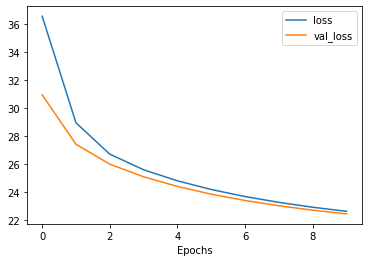

In [22]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [34]:
test_dataset_1??

In [35]:
gene_list

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [43]:
gene_list

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [45]:
# TO DO

# 1. deterministic write pipeline for producing df w [mean, std, actual]
# 1.5. train ensemble
# 2. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
# 3. produce plot showing the selective prediction w uncertainty thresholding
# 4. produce plot showing histology slide with companion aleatoric, epistemic, and total

# 
# Draft results by end of week 2 (Feb-17th)

(2338, 14)

In [ ]:
test_dataset_1

In [23]:
pred_test_1 = model.predict(test_gen__1)

In [111]:
pred_test_2 = model.predict(test_gen__2)

In [46]:
df_target_1 = test_dataset_1.to_df().loc[:, gene_list]

In [48]:
df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [89]:
df_temp.head()

,mean,var,std,target
0,2.935439,4.074678,2.018583,2.944439
1,5.838997,11.633478,3.410788,1.098612
2,7.910624,17.247154,4.152969,2.079442
3,4.063245,6.980574,2.642078,1.098612
4,4.097795,6.987684,2.643423,0.693147


In [114]:
def get_results(df_target, np_preds, list_genes):
    
    # instantiate dictionary
    dict_results = {}
    
    for gene_idx, gene_name in enumerate(list_genes):
        
        # actual 
        target = df_target[gene_name]

        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        
        # mean, var, std 
        mu, var = nbinom.stats(n, p, moments='mv')
        std = np.sqrt(var)

        # create dataframe
        df_temp = pd.DataFrame(
            data=np.stack([mu, var, std, target], axis=1), 
            columns=['mean', 'var', 'std', 'target'],
            index= df_target.index
        )
        
        # append dictionary
        dict_results[gene_name] = df_temp
        
    return dict_results

In [98]:
df_target = df_target_1.copy()
np_preds = pred_test_1.copy()
list_genes = gene_list.copy()

In [107]:
dict_res1 = get_results(
    df_target = df_target_1, 
    np_preds = pred_test_1,
    list_genes = gene_list
)

In [115]:
dict_res2 = get_results(
    df_target = df_target_2, 
    np_preds = pred_test_2,
    list_genes = gene_list
)

In [128]:
df_res1_all = pd.concat([dict_res1[g] for g in dict_res1.keys()], axis=0)
df_res2_all = pd.concat([dict_res2[g] for g in dict_res2.keys()], axis=0)

In [129]:
df_res_all = pd.concat([df_res1_all, df_res2_all], axis=0)

In [131]:
pearsonr(df_res1_all['target'], df_res1_all['mean'])

(0.2762159394096582, 0.0)

In [132]:
pearsonr(df_res2_all['target'], df_res2_all['mean'])

(0.5736514250260873, 0.0)

In [130]:
pearsonr(df_res_all['target'], df_res_all['mean'])

(0.4494130066977668, 0.0)

In [121]:
pearsonr(dict_res2['COX6C']['mean'], dict_res2['COX6C']['target'])

(-0.1027875138788497, 1.0353204570941155e-12)

In [117]:
dict_res2['COX6C'].head()

,mean,var,std,target
TGGTACCGGCACAGCC-1-1160920F,3.259137,5.483247,2.341633,0.000000
GCGCGTTTAAATCGTA-1-1160920F,2.897606,4.424093,2.103353,0.693147
TGCCTTGCCCTTACGG-1-1160920F,4.820837,9.262687,3.043466,1.098612
GACGACTTTCCAAGAA-1-1160920F,3.893397,6.666375,2.581932,1.791759
CCAGTGAGCTCCTTGT-1-1160920F,1.962099,2.708454,1.645738,0.000000
